In [1]:
import geopandas as gpd
import rasterio as rio
from rasterio import features
from rasterio import Affine
from rasterio.plot import show
import rioxarray as riox
import xarray as xr
import glob
import os
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from rasterio.enums import Resampling
import dask
from dask.distributed import LocalCluster, Client

In [2]:
cluster = LocalCluster(n_workers=8, threads_per_worker=2)
cl = Client(cluster)
cl

distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-4n93k_ng', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-ay4donjz', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-dyfx16w8', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-f2bxnrzt', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-kbirxzmm', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-mayjmzs9', purging
distributed.diskutils - INFO - Fou

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 15.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45031,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.49 GiB
Comm: tcp://127.0.0.1:36643,Total threads: 2
Dashboard: http://127.0.0.1:43471/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:42601,


In [88]:
# pasture boundaries
cper_f = './ground_data/pastures/cper_boundary_buff50_mask.shp'

# HLS directory
hls_path = '/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/data/gcloud/hls_cper_*_gcloud.nc'

# september inputs
colony_f = './ground_data/historical/tifs/pdog_binary_2011_2021_30m.nc'

# ecosites
eco_f = '/mnt/d/CPER/data/vectors/Ecosites/Ecological_Site_Name.shp'

# prairie dog suitabilitiy (HOTR)
hotr_f = '/mnt/d/HOTR/ensemble_wave_Jan192021/HOTR.tif'

yr_start = 2013
yr_end = 2021
cell_size = 30.0

### Additional helper functions

##### General functions

In [4]:
def shp2mask(shp, xr_object, transform, outshape, fill=0, dtype='int16', **kwargs):
    raster = features.rasterize(shp, fill=fill, transform=transform,
                                out_shape=outshape, dtype=dtype, **kwargs)
    return xr.DataArray(raster,
                        coords=(xr_object.coords['y'].values, xr_object.coords['x']),
                        dims=('y', 'x'))

def apply_slope(y):
    from sklearn.linear_model import LinearRegression
    X = np.arange(0, len(y))
    if len(y[~np.isnan(y)]) > 3:
        ts = LinearRegression().fit(X[~np.isnan(y)].reshape(-1, 1), y[~np.isnan(y)])
        return ts.coef_
    else:
        return np.nan
    
def apply_zscore(da):
    return (da - da.mean()) / da.std()

In [5]:
#xr.backends.file_manager.FILE_CACHE.clear()

In [96]:
[(gdf_cper['geometry'], 1)]

[(0    MULTIPOLYGON (((536705.992 4528708.329, 537062...
  Name: geometry, dtype: geometry,
  1)]

In [100]:
# load CPER shapefile
gdf_cper = gpd.read_file(cper_f)
gdf_cper = gdf_cper.set_crs(32613)
#cper_xr = shp2mask([(gdf_cper['geometry'], 1)], da_colony, da_colony.rio.transform, da_colony.sel(Year=2020).shape)

In [106]:
# load colony maps
da_colony = riox.open_rasterio(colony_f, masked=True)
da_colony.name = 'colony'
da_colony = da_colony.rio.clip(gdf_cper['geometry'], invert=True)

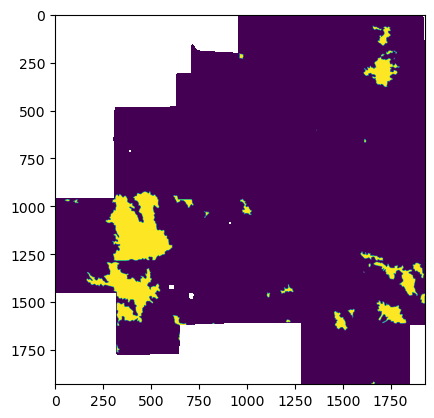

<AxesSubplot:>

In [107]:
show(da_colony.sel(Year=2020).data)

In [108]:
# load hotr map
da_hotr = riox.open_rasterio(hotr_f, masked=True).squeeze()

da_hotr = da_hotr.rio.clip_box(minx=da_colony.x.min(), miny=da_colony.y.min(),
                               maxx=da_colony.x.max(), maxy=da_colony.y.max(),
                               crs=da_colony.rio.crs).rio.reproject('EPSG:32613')
da_hotr = da_hotr.rio.clip(gdf_cper['geometry'], invert=True)

In [109]:
# load ecosite map
gdf_eco = gpd.read_file(eco_f)

In [118]:
eco_info = gdf_eco[['EcoSiteNm', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
eco_dict = {row.id+1: row.EcoSiteNm for _, row in eco_info.iterrows()}
eco_dict[0] = 'None'
eco_mask_shp = [(row.geometry, row.id+1) for _, row in eco_info.iterrows()]
eco_mask = shp2mask(shp=eco_mask_shp, 
                     transform=da_colony.rio.transform(), 
                     outshape=da_colony.shape[1:], 
                     xr_object=da_colony)
eco_mask = eco_mask.rio.write_crs(gdf_eco.crs)

eco_mask = eco_mask.rio.clip(gdf_cper['geometry'], invert=True)

### Bring in biomass and cover data

In [11]:
hls_f_LIST = glob.glob(hls_path)
hls_f_LIST

['/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/data/gcloud/hls_cper_2013_gcloud.nc',
 '/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/data/gcloud/hls_cper_2014_gcloud.nc',
 '/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/data/gcloud/hls_cper_2015_gcloud.nc',
 '/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/data/gcloud/hls_cper_2016_gcloud.nc',
 '/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/data/gcloud/hls_cper_2017_gcloud.nc',
 '/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/data/gcloud/hls_cper_2018_gcloud.nc',
 '/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/data/gcloud/hls_cper_2019_gcloud.nc',
 '/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/data/gcloud/hls_cper_2020_gcloud.nc',
 '/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/data/gcloud/hls_cper_2021_gcloud.nc',
 '/mnt/c/Users/TBGPEA-Sean/git_repos/hls_nrt/data/gcloud/hls_cper_2022_gcloud.nc']

In [12]:
hls_xr_LIST = []
for hls_f in tqdm(hls_f_LIST):
    hls_xr_tmp = riox.open_rasterio(hls_f,
                                decode_times=True,
                                chunks={'date': -1, 'x': 50, 'y': 50},
                                masked=True)
    hls_xr_tmp['Year'] = np.unique(hls_xr_tmp['date'].dt.year)[0]
    hls_xr_tmp['date'] = hls_xr_tmp['date'].dt.dayofyear
    hls_xr_tmp = hls_xr_tmp.rename({'date': 'DOY'})
    hls_xr_LIST.append(hls_xr_tmp)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.65it/s]


In [13]:
hls_xr = xr.concat(hls_xr_LIST, dim='Year')

In [14]:
bm_slope = xr.apply_ufunc(apply_slope,
                          hls_xr['Biomass'].sel(DOY=slice(200, 250)).groupby('Year'),
                          input_core_dims=[['DOY']],
                          vectorize=True,
                          dask='parallelized')
bm_slope = bm_slope.rio.reproject('EPSG:32613').compute()
bm_slope = bm_slope.where((bm_slope > -20) & (bm_slope < 20))
bm_slope_z = bm_slope.groupby('Year').apply(apply_zscore)

In [15]:
bare_slope = xr.apply_ufunc(apply_slope,
                          hls_xr['BARE'].isel(DOY=slice(200, 250)).groupby('Year'),
                          input_core_dims=[['DOY']],
                          vectorize=True,
                          dask='parallelized')
bare_slope = bare_slope.rio.reproject('EPSG:32613').compute()
bare_slope = bare_slope.where((bare_slope > -20.0) & (bare_slope < 20.0))
bare_slope_z = bare_slope.groupby('Year').apply(apply_zscore)

In [16]:
bm_sub = hls_xr['Biomass'].isel(DOY=slice(235, 265)).groupby('Year').mean(dim='DOY').rio.reproject('EPSG:32613').compute()
bm_sub = bm_sub.where(bm_sub != bm_sub.rio.nodata)
bm_z = bm_sub.groupby('Year').apply(apply_zscore)

/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


In [17]:
bare_sub = hls_xr['BARE'].isel(DOY=slice(235, 265)).groupby('Year').mean(dim='DOY').rio.reproject('EPSG:32613').compute()
bare_sub = bare_sub.where(bare_sub != bare_sub.rio.nodata)
bare_z = bare_sub.groupby('Year').apply(apply_zscore)

/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


In [112]:
bm_z = bm_z.rio.clip(gdf_cper['geometry'], invert=True)
bm_slope_z = bm_slope_z.rio.clip(gdf_cper['geometry'], invert=True)
bare_z = bare_z.rio.clip(gdf_cper['geometry'], invert=True)
bare_slope_z = bare_slope_z.rio.clip(gdf_cper['geometry'], invert=True)

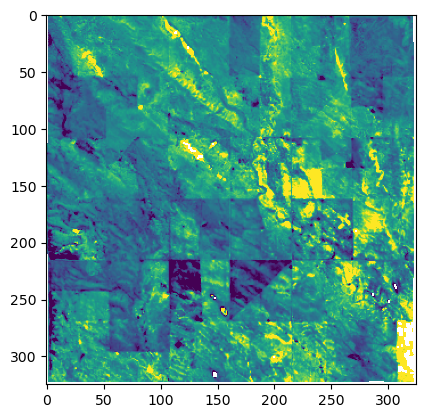

<AxesSubplot:>

In [18]:
show(bm_slope_z.sel(Year=2021).data, clim=(-2.0, 2.0))

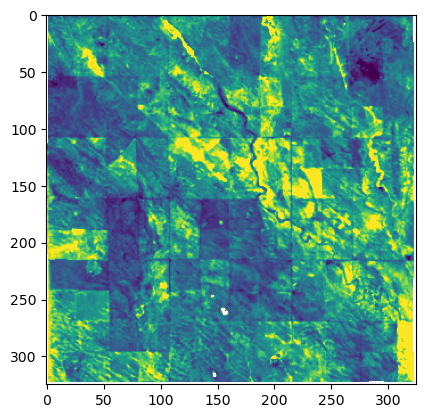

<AxesSubplot:>

In [19]:
show(bm_z.sel(Year=2021).data, clim=(-2.0, 2.0))

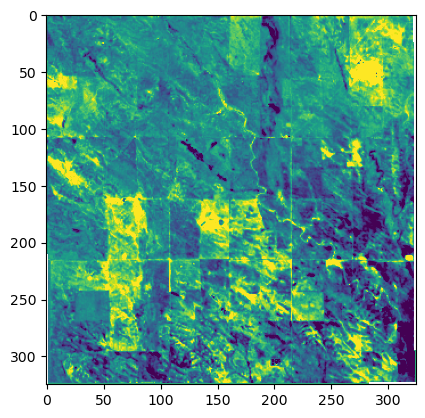

<AxesSubplot:>

In [20]:
show(bare_slope_z.sel(Year=2021).data, clim=(-2.0, 2.0))

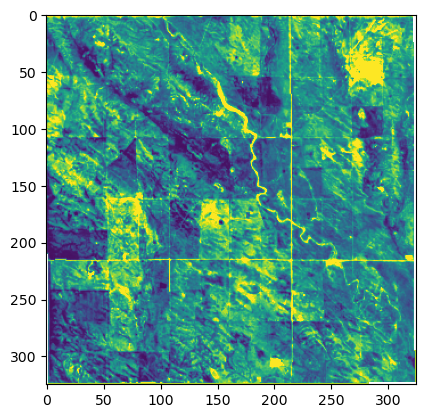

<AxesSubplot:>

In [21]:
show(bare_z.sel(Year=2021).data, clim=(-2.0, 2.0))

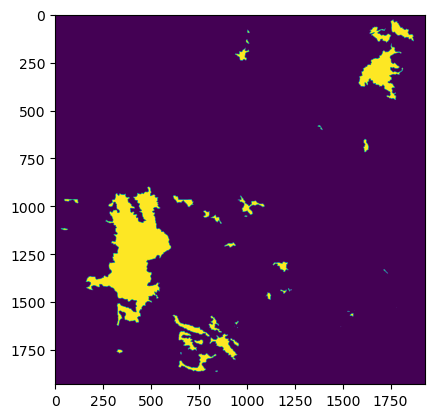

<AxesSubplot:>

In [22]:
show(da_colony.sel(Year=2021).data)

In [119]:
df_colony = da_colony.where(da_colony['Year'].isin(np.unique(bm_sub['Year'].values)), drop=True).rio.reproject(
    bm_sub.rio.crs,
    shape=bm_sub.isel(Year=0).shape,
    resampling=Resampling.mode).reindex_like(bm_sub, method='nearest').to_dataframe(name='colony').drop(columns=['spatial_ref'])

In [120]:
df_colony['bm_z'] = bm_z.sel(Year=slice(yr_start, yr_end)).to_dataframe(name='bm_z').drop(columns=['spatial_ref'])
df_colony['bm_slope_z'] = bm_slope_z.sel(Year=slice(yr_start, yr_end)).to_dataframe(name='bm_slope_z').drop(columns=['spatial_ref'])
df_colony['bare_z'] = bare_z.sel(Year=slice(yr_start, yr_end)).to_dataframe(name='bare_z').drop(columns=['spatial_ref'])
df_colony['bare_slope_z'] = bare_slope_z.sel(Year=slice(yr_start, yr_end)).to_dataframe(name='bare_slope_z').drop(columns=['spatial_ref'])

In [121]:
#df_colony = df_colony.dropna(how='any')
df_colony = df_colony.reset_index(level='Year')

In [122]:
df_colony['hotr'] = da_hotr.reindex_like(bm_sub, method='nearest').to_dataframe(name='hotr').drop(columns=['spatial_ref', 'band'])

In [123]:
df_colony['ecosite'] = eco_mask.rio.reproject(
    bm_sub.rio.crs,
    shape=bm_sub.isel(Year=0).shape,
    resampling=Resampling.mode).reindex_like(bm_sub, method='nearest').to_dataframe(name='colony').drop(columns=['spatial_ref'])
df_colony['ecosite'] = df_colony['ecosite'].apply(lambda x: eco_dict[x])

In [124]:
df_colony = df_colony.reset_index()

In [30]:
cl.restart()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 15.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45031,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: 4 minutes ago,Total memory: 15.49 GiB
Comm: tcp://127.0.0.1:32981,Total threads: 2
Dashboard: http://127.0.0.1:41015/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:42601,


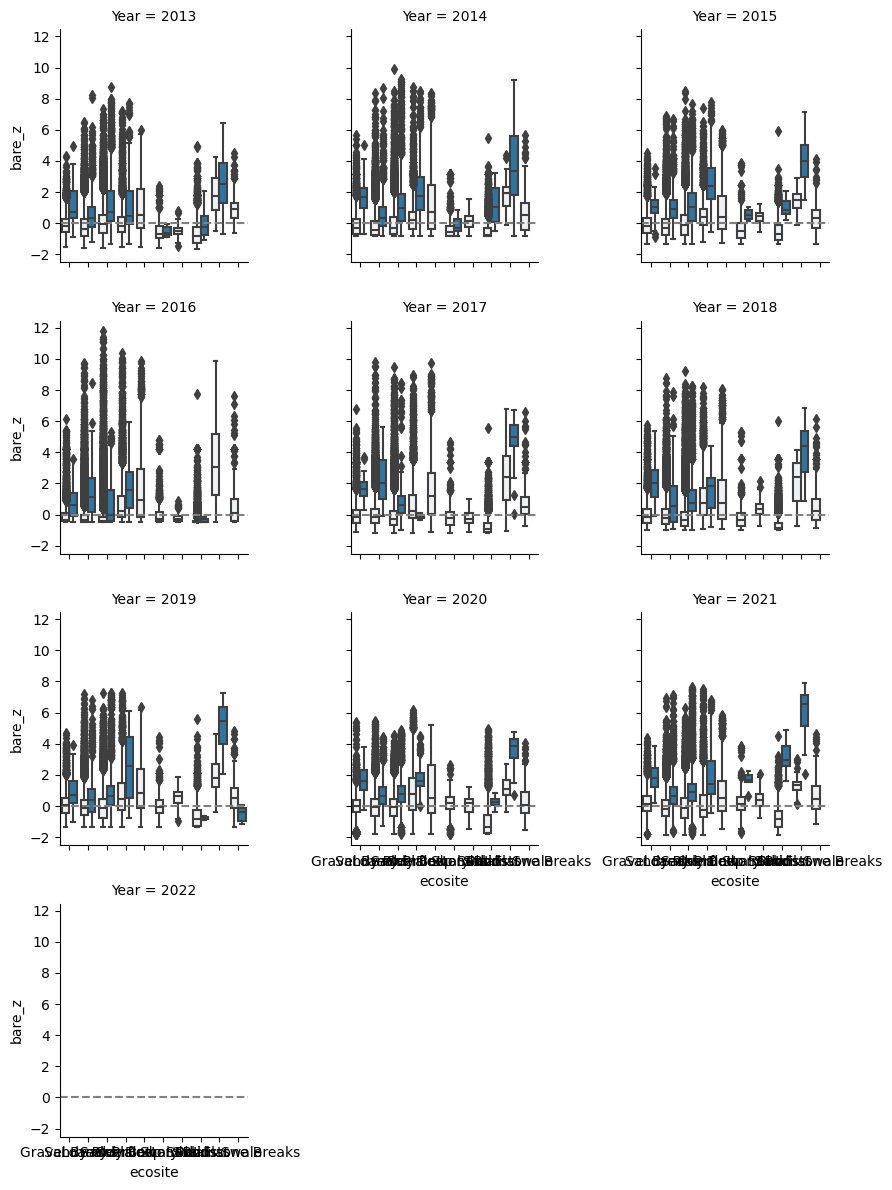

In [31]:
g = sns.FacetGrid(data=df_colony, col='Year', col_wrap=3)
g.map_dataframe(sns.boxplot, x='ecosite', y='bare_z', hue='colony', dodge=True)
for ax in g.axes.flatten():
    ax.axhline(y=0, linestyle='dashed', color='grey')

In [74]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression

In [33]:
ordinal_encoder = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        make_column_selector(dtype_include=object),
    ),
    remainder="passthrough"
)

one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        make_column_selector(dtype_include=object),
    ),
    remainder="passthrough",
)

In [142]:
df_X = df_colony.dropna(axis=0, how='any')[['bare_z', 'bm_z', 'bare_slope_z', 'bm_slope_z', 'hotr', 'ecosite']]#.values
df_y = df_colony.dropna(axis=0, how='any')['colony']#.values

In [143]:
x_train, x_test, y_train, y_test = train_test_split(df_X, df_y, test_size = .25, random_state = 18)

In [144]:
#clf = make_pipeline(
#    ordinal_encoder, HistGradientBoostingClassifier(loss='log_loss', max_iter=500, learning_rate=0.01,
#                                     verbose=False, class_weight="balanced", 
#                                     monotonic_cst=[0, 1, -1, 1, -1, 1], 
#                                     categorical_features=[True, False, False, False, False, False],
#                                     random_state = 21)
#)

In [145]:
clf = make_pipeline(
    ordinal_encoder, RandomForestClassifier(n_estimators = 500, criterion='log_loss',
                                            bootstrap = True, verbose=True, n_jobs=-1, class_weight="balanced_subsample",
                                            random_state = 18)
)

In [127]:
clf = make_pipeline(
    one_hot_encoder, LogisticRegression(class_weight='balanced', random_state=18, n_jobs=-1, max_iter=1000))

In [146]:
clf.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe3e6022d90>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        criterion='log_loss', n_estimators=500,
                                        n_jobs=-1, random_state=18,
                                        verbose=True))])

In [338]:
#clf = RandomForestClassifier(n_estimators = 500, criterion='log_loss',
#                             bootstrap = True, verbose=True, n_jobs=-1, class_weight="balanced_subsample",
#                             random_state = 18)
#clf = HistGradientBoostingClassifier(loss='log_loss', max_iter=500, learning_rate=0.01,
#                                     verbose=False, class_weight="balanced", 
#                                     monotonic_cst={'bare_z': 1, 'bm_z': -1, 'bare_slope_z': 1, 'bm_slope_z': -1, 'hotr': 1, 'ecosite': 0}, 
#                                     categorical_features=[False, False, False, False, False, True],
#                                     random_state = 21)

#clf = MLPClassifier(activation='relu', solver='adam', alpha=1.0e-7)

#clf.fit(x_train, y_train)

In [147]:
# Create our predictions
prediction = clf.predict(x_test)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    1.4s finished


In [148]:
# Create confusion matrix
from sklearn.metrics import recall_score, precision_score, jaccard_score, confusion_matrix, f1_score, accuracy_score
confusion_matrix(y_test, prediction)

array([[166462,    494],
       [  6054,   1685]])

In [155]:
# Display accuracy score
recall_score(y_test, prediction)

0.2177283886807081

In [150]:
# Display F1 score
f1_score(y_test, prediction)

0.3397862472272636

In [151]:
clf.named_steps['randomforestclassifier'].feature_importances_

array([0.03560505, 0.19856762, 0.32898666, 0.14621693, 0.14997564,
       0.14064811])

In [152]:
df_2022 = bm_z.sel(Year=2022).to_dataframe(name='bm_z').drop(columns=['spatial_ref'])
df_2022['bm_slope_z'] = bm_slope_z.sel(Year=2022).to_dataframe(name='bm_slope_z').drop(columns=['spatial_ref', 'Year'])
df_2022['bare_z'] = bare_z.sel(Year=2022).to_dataframe(name='bare_z').drop(columns=['spatial_ref', 'Year'])
df_2022['bare_slope_z'] = bare_slope_z.sel(Year=2022).to_dataframe(name='bare_slope_z').drop(columns=['spatial_ref', 'Year'])
df_2022['hotr'] = da_hotr.reindex_like(bm_sub, method='nearest').to_dataframe(name='hotr').drop(columns=['spatial_ref', 'band'])
df_2022['ecosite'] = eco_mask.rio.reproject(
    bm_sub.rio.crs,
    shape=bm_sub.isel(Year=0).shape,
    resampling=Resampling.mode).reindex_like(bm_sub, method='nearest').to_dataframe(name='colony').drop(columns=['spatial_ref'])
df_2022['ecosite'] = df_2022['ecosite'].apply(lambda x: eco_dict[x])

In [153]:
# use for Histogram Gradient Boosting
#prediction_yr = clf.predict_proba(df_2022[['bare_z', 'bm_z', 'bare_slope_z', 'bm_slope_z', 'hotr', 'ecosite']])[:, 1]
#show(prediction_yr.reshape(bm_sub.isel(Year=1).shape))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    0.6s finished


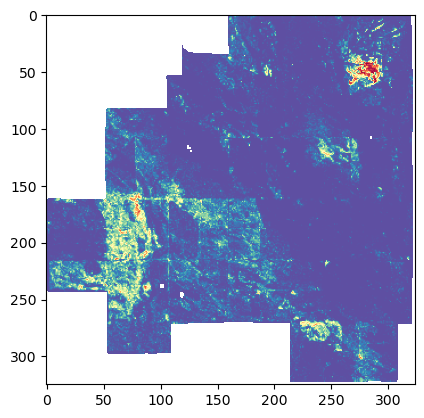

<AxesSubplot:>

In [154]:
# use for random forest
x_yr_mask = df_2022[['bare_z', 'bm_z', 'bare_slope_z', 'bm_slope_z', 'hotr']].isnull().any(axis=1)

x_yr = df_2022[['bare_z', 'bm_z', 'bare_slope_z', 'bm_slope_z', 'hotr', 'ecosite']].dropna(axis=0, how='any')
prediction_yr = np.zeros_like(x_yr_mask) * np.nan
prediction_yr[~x_yr_mask] = clf.predict_proba(x_yr)[:, 1]
show(prediction_yr.reshape(bm_z.isel(Year=1).shape), cmap='Spectral_r', clim=(0, 1.0))

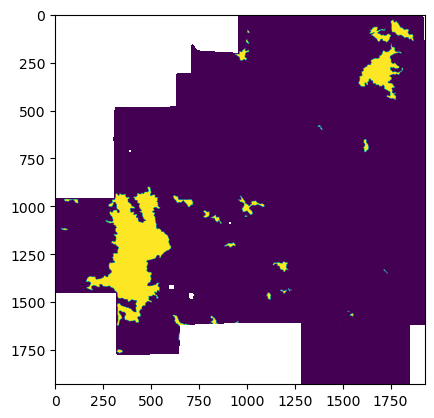

<AxesSubplot:>

In [141]:
show(da_colony.sel(Year=2021).data)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    0.8s finished


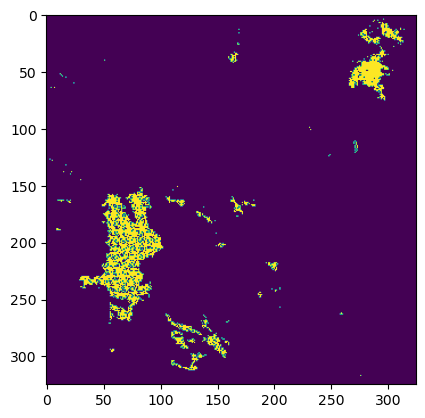

<AxesSubplot:>

In [173]:
# use for method without column transform
x_yr = df_colony[df_colony['Year'] == 2021][['bare_z', 'bm_z', 'bare_slope_z', 'bm_slope_z', 'hotr']].values
prediction_yr = np.zeros_like(x_yr[:, 0]) * np.nan
prediction_yr[~np.any(np.isnan(x_yr), axis=1)] = clf.predict_proba(x_yr[~np.any(np.isnan(x_yr), axis=1), :])[:, 1]
show(prediction_yr.reshape(bm_sub.isel(Year=1).shape) > 0.5)

In [79]:
x_yr = df_2022[['bare_z', 'bm_z', 'bare_slope_z', 'bm_slope_z', 'hotr']]
#prediction_yr = np.zeros_like(x_yr['bare_z'].values) * np.nan
prediction_yr = clf.predict_proba(x_yr)[:, 1]
show(prediction_yr.reshape(bm_sub.isel(Year=1).shape))

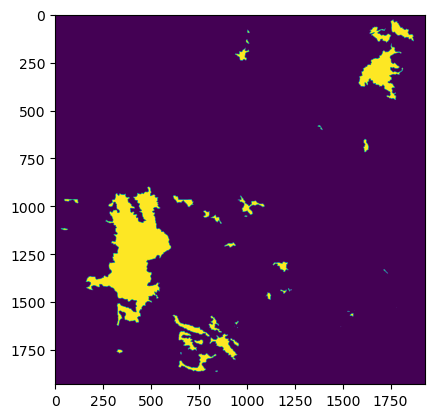

<AxesSubplot:>

In [159]:
x_yr = df_colony[df_colony['Year'] == 2020][['bare_z', 'bm_z', 'bare_slope_z', 'bm_slope_z', 'hotr']]
prediction_yr = clf.predict_proba(x_yr)[:, 1]
show(prediction_yr.reshape(bm_sub.isel(Year=1).shape))

/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    0.8s finished


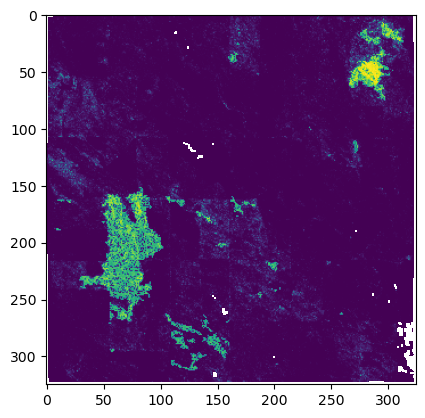

<AxesSubplot:>

In [160]:
x_yr = df_colony[df_colony['Year'] == 2021][['bare_z', 'bm_z', 'bare_slope_z', 'bm_slope_z', 'hotr']].values
prediction_yr = np.zeros_like(x_yr[:, 0]) * np.nan
prediction_yr[~np.any(np.isnan(x_yr), axis=1)] = clf.predict_proba(x_yr[~np.any(np.isnan(x_yr), axis=1), :])[:, 1]
show(prediction_yr.reshape(bm_sub.isel(Year=1).shape))

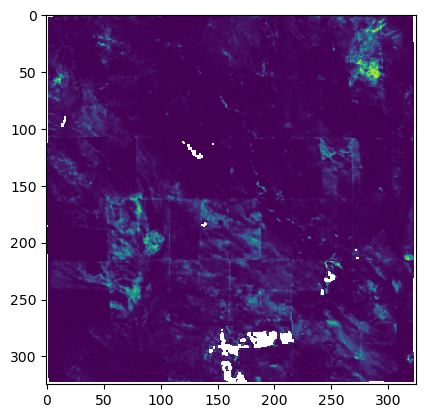

<AxesSubplot:>